# Running this code

Please ensure you `make install` in the root directory to install all dependencies needed, and then you can point this notebook interpretter to the `.venv/bin/python` and it should run smoothly.

In [ ]:
from pathlib import Path
from typing import no_type_check

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import sep
from astropy.coordinates import Galactic
from astropy.io import fits
from astropy.wcs import WCS
from loguru import logger
from matplotlib.patches import Ellipse
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm

from jades_sky_fraction.download import get_pearls_image

plt.rcParams["figure.dpi"] = 300

In [3]:
path = get_pearls_image()
hdul = fits.open(path)
wcs = WCS(hdul[0].header)

Set DATE-AVG to '2022-09-04T19:28:28.041' from MJD-AVG.
Set DATE-END to '2022-09-14T12:26:58.795' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -22.091840 from OBSGEO-[XYZ].
Set OBSGEO-H to 1543654444.803 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [4]:
# Following Sep tutorial
data = hdul[0].data
data = data.astype(data.dtype.newbyteorder("="))
mask = data == 0

In [5]:
coords = np.argwhere(np.ones_like(data))
sky_coords = wcs.pixel_to_world(coords[:, 1], coords[:, 0])
gal_coords = sky_coords.transform_to(Galactic)
b = gal_coords.b.deg.reshape(data.shape)

  0%|          | 0/5 [00:00<?, ?it/s]

2025-02-13 14:28:39.200 | INFO     | __main__:get_sky_fraction:50 - Found 10698 objects when extracting with psf_mas=0
2025-02-13 14:28:45.039 | INFO     | __main__:get_sky_fraction:50 - Found 13888 objects when extracting with psf_mas=30
2025-02-13 14:28:52.456 | INFO     | __main__:get_sky_fraction:50 - Found 13664 objects when extracting with psf_mas=60
2025-02-13 14:29:00.801 | INFO     | __main__:get_sky_fraction:50 - Found 11681 objects when extracting with psf_mas=90
2025-02-13 14:29:10.180 | INFO     | __main__:get_sky_fraction:50 - Found 10016 objects when extracting with psf_mas=120


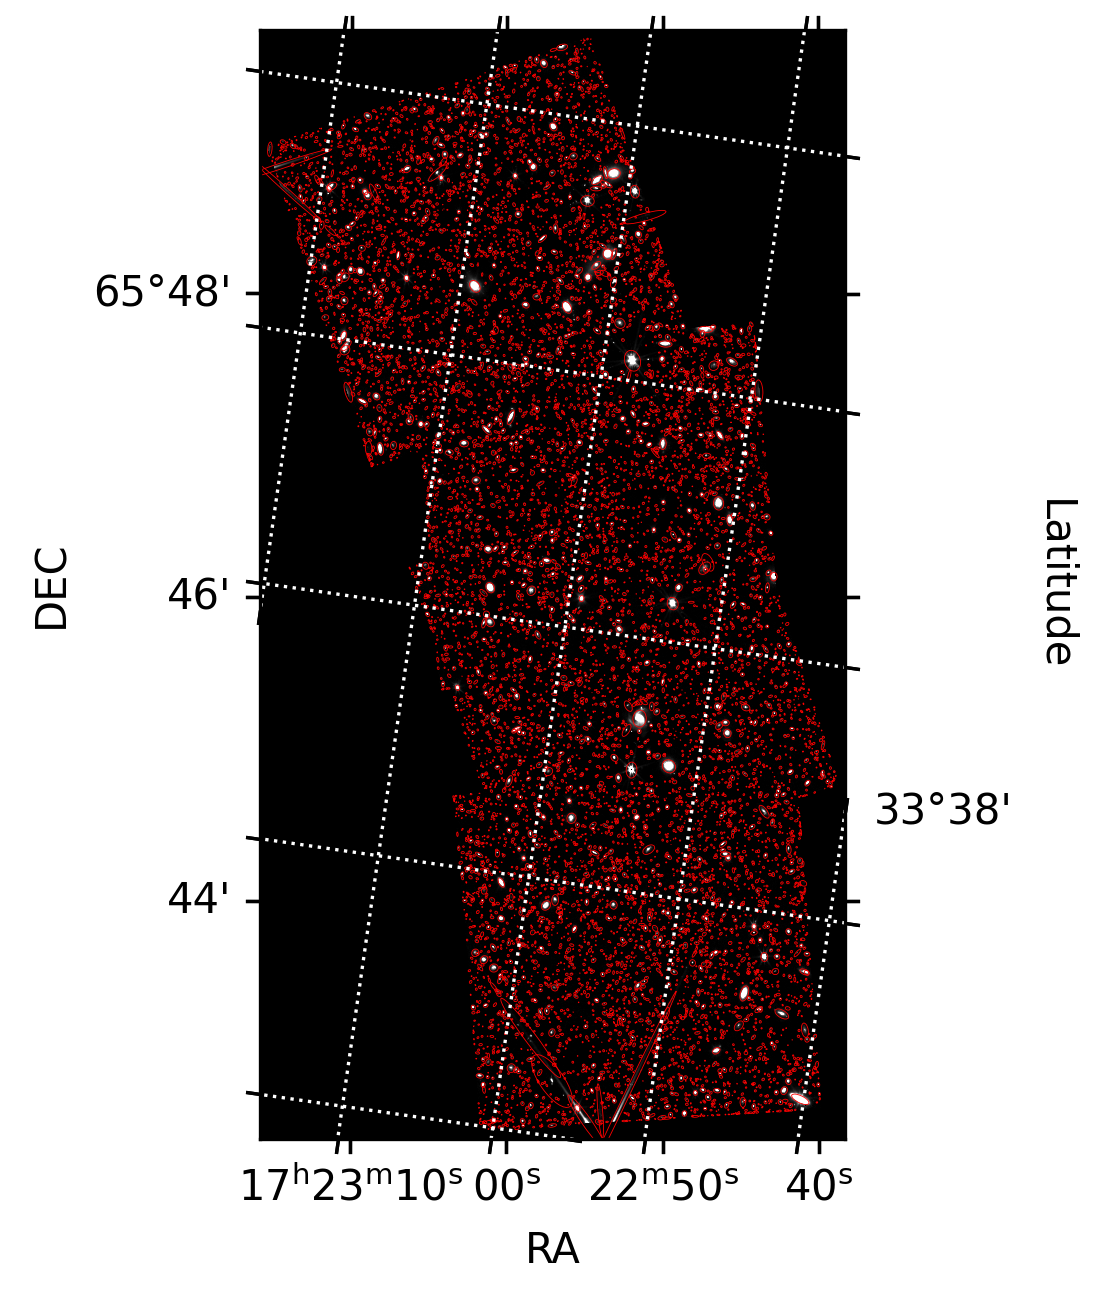

In [ ]:
def apply_psf(data: np.ndarray, mask: np.ndarray, psf_mas: float, wcs: WCS) -> np.ndarray:
    if psf_mas == 0:
        return data
    # TODO: Im not sure if there's an easy way to do pixels->mas, or if I need to use the WCS.
    # mas_per_pixel = wcs.pixel_to_world(0, 0).separation(wcs.pixel_to_world(1, 0)).mas  # type: ignore  # noqa: PGH003
    # Ah, I note now that the image I downloaded has 30mas in the name, so the above giving 30 makes sense
    mas_per_pixel = 30
    gaussian_std_pixels = psf_mas / mas_per_pixel
    data_smooth = gaussian_filter(data, gaussian_std_pixels)
    data_smooth[mask] = 0
    return data_smooth


@no_type_check
def plot_image(data: np.ndarray, wcs: WCS, objects: list):
    m, s = np.mean(data), np.std(data)

    ax = plt.subplot(projection=wcs, label="overlays")
    ax.imshow(data, interpolation="nearest", cmap="gray", vmin=0, vmax=m + s, origin="lower")
    ax.coords[0].set_axislabel("RA")
    ax.coords[1].set_axislabel("DEC")
    overlay = ax.get_coords_overlay("galactic")
    overlay.grid(color="white", ls="dotted")
    overlay[0].set_axislabel("Longitude")
    overlay[1].set_axislabel("Latitude")
    # plot an ellipse for each object
    for i in range(len(objects)):
        e = Ellipse(
            xy=(objects["x"][i], objects["y"][i]),
            width=6 * objects["a"][i],
            height=6 * objects["b"][i],
            angle=objects["theta"][i] * 180.0 / np.pi,
            linewidth=0.2,
        )
        e.set_facecolor("none")
        e.set_edgecolor("red")
        ax.add_artist(e)


def get_sky_fraction(
    data_original: np.ndarray,
    mask: np.ndarray,
    wcs: WCS,
    psf_mas: float = 0.0,
    plot: bool = False,
) -> pl.DataFrame:
    data = apply_psf(data_original, mask, psf_mas, wcs)
    bkg = sep.Background(data, mask=mask)
    data_sub = data - bkg
    objects, segmentation_map = sep.extract(data_sub, 2.5, err=bkg.globalrms, mask=mask, segmentation_map=True)
    logger.info(f"Found {len(objects)} objects when extracting with psf_mas={psf_mas}")
    if plot:
        plot_image(data, wcs, objects)

    is_sky = segmentation_map == 0
    return (
        pl.concat([
            pl.DataFrame({"b": b[~is_sky & ~mask], "sky": False}),
            pl.DataFrame({"b": b[is_sky & ~mask], "sky": True}),
        ])
        .with_columns(b_rounded=pl.col("b").round(3))
        .group_by("b_rounded")
        .agg(
            pl.col("sky").cast(pl.Float64).mean().alias("sky_fraction"),
            pl.len().alias("n_pixels"),
        )
        .sort("b_rounded")
        .with_columns(psf_mas=psf_mas)
    )


dfs = []
psfs = [0, 30, 60, 90, 120]
for i in tqdm(range(len(psfs))):
    psf_mas = psfs[i]
    dfs.append(get_sky_fraction(data, mask, wcs, psf_mas, plot=psf_mas == 120))

df = pl.concat(dfs).sort("b_rounded", "psf_mas")

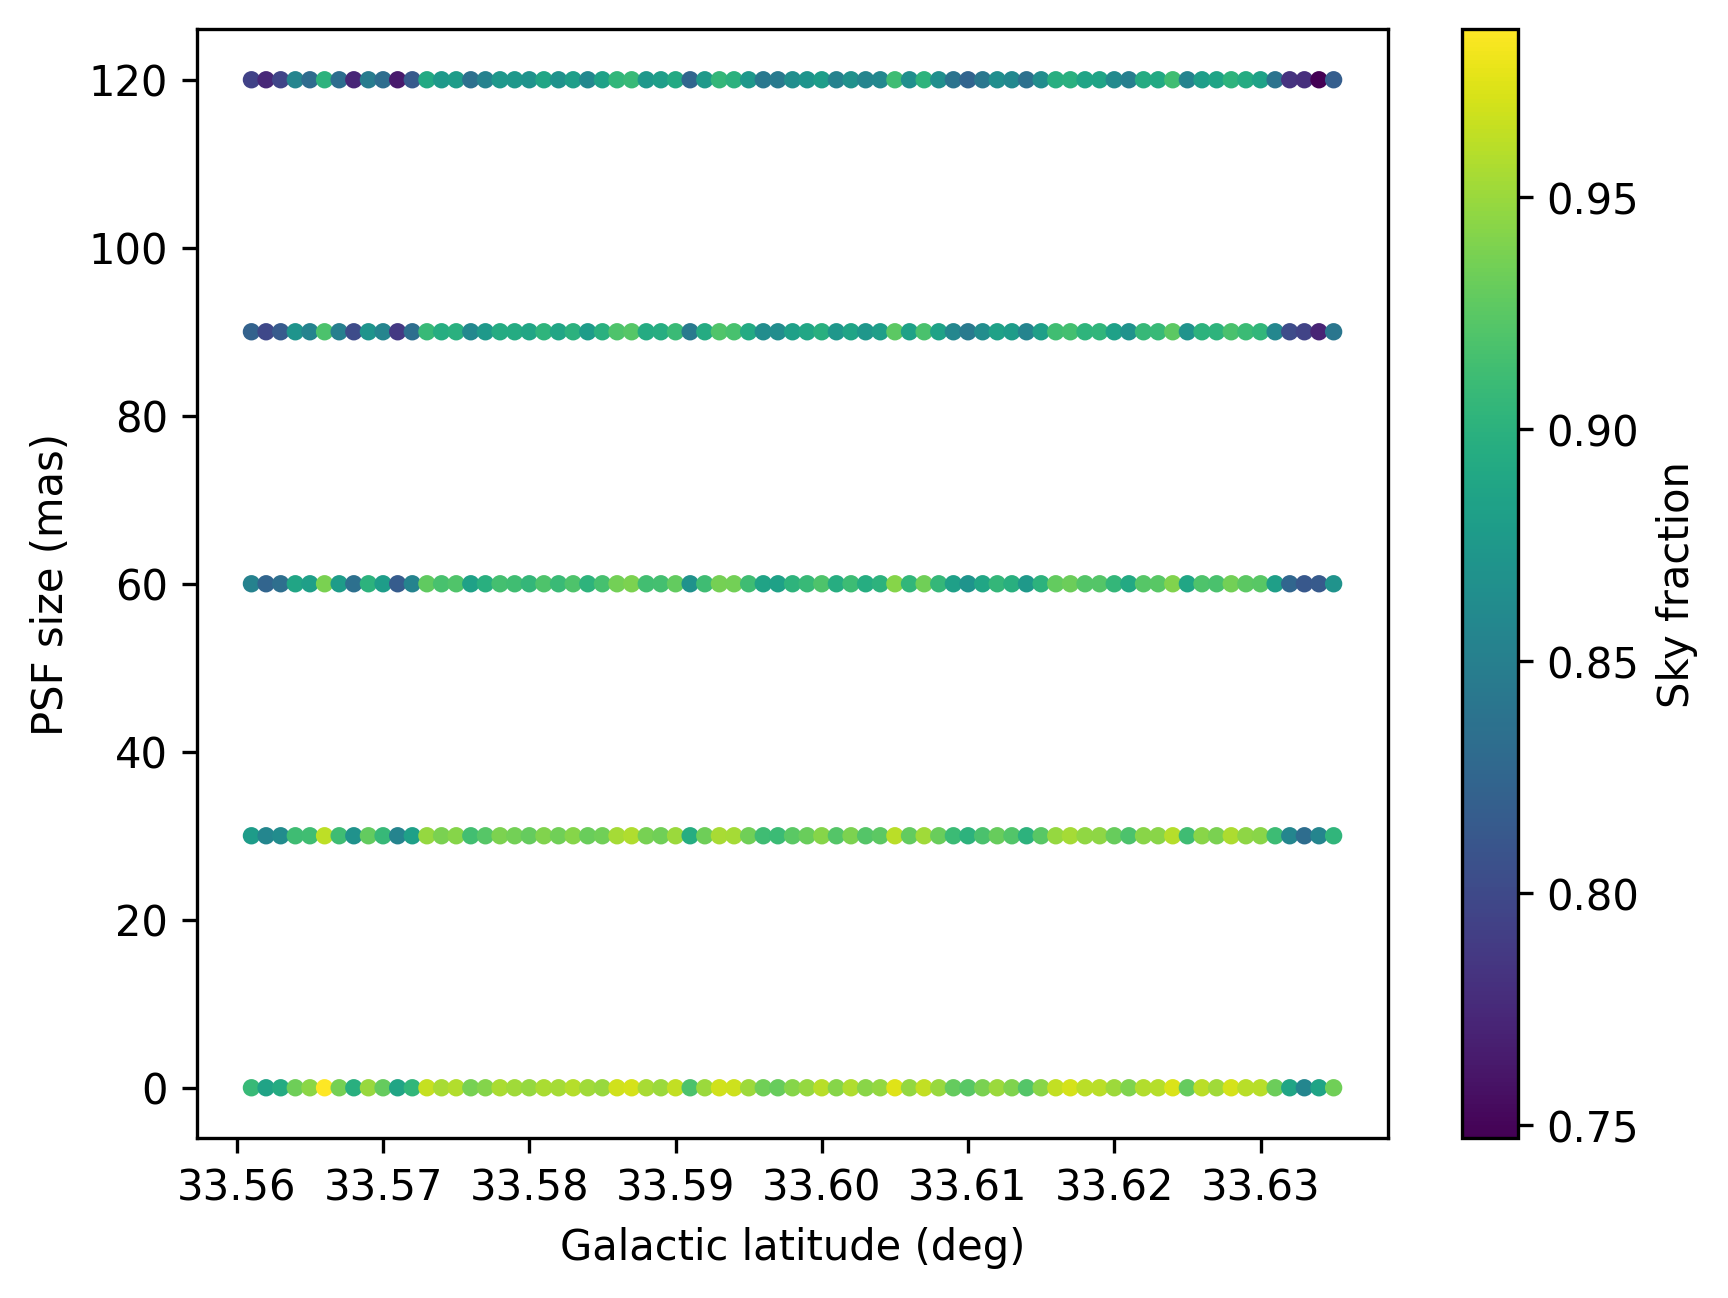

In [39]:
# Turn the dataframe into a 2D numpy array, with one dimension being the galactic latitude and the other being the PSF size.
df = df.filter(pl.col("b_rounded") != pl.col("b_rounded").min())
fig, ax = plt.subplots()
ax.set_xlabel("Galactic latitude (deg)")
ax.set_ylabel("PSF size (mas)")
handle = ax.scatter(df["b_rounded"], df["psf_mas"], c=df["sky_fraction"], cmap="viridis", s=10)
plt.colorbar(handle, label="Sky fraction");

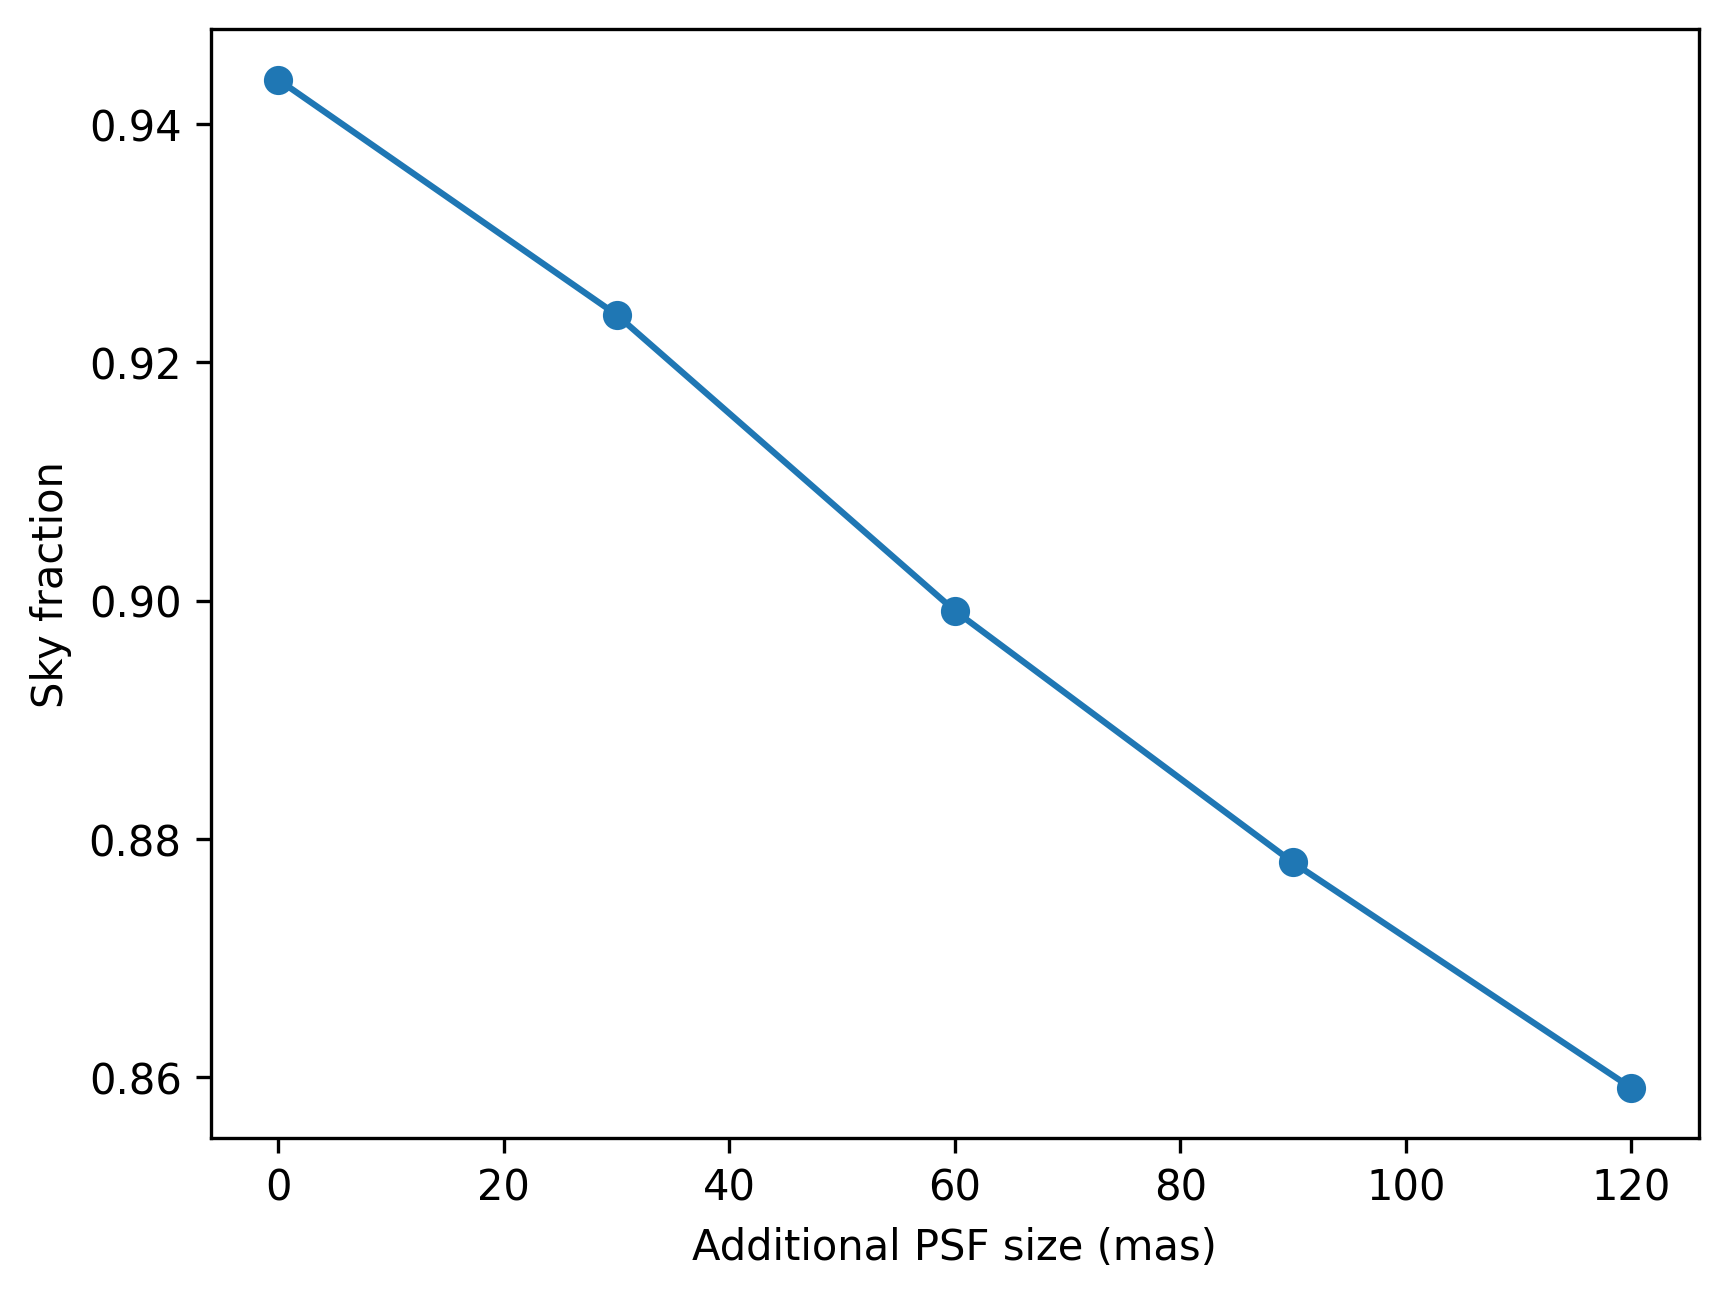

In [46]:
df_combined = (
    df.group_by("psf_mas")
    .agg(pl.col("sky_fraction").mean().alias("sky_fraction"), pl.col("n_pixels").sum())
    .sort("psf_mas")
)


fig, ax = plt.subplots()
ax.set_xlabel("Additional PSF size (mas)")
ax.set_ylabel("Sky fraction")
ax.plot(df_combined["psf_mas"], df_combined["sky_fraction"], marker="o")

output_dir = Path("output")
output_dir.mkdir(exist_ok=True)
fig.savefig(output_dir / "sky_fraction_vs_psf_size.png", dpi=200, bbox_inches="tight")